# Spotify Song Data API Request

In [2]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import timeit

In [186]:
#File with API keys and tokens
%run ./SpotifyConfig.ipynb

In [187]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [344]:
# timeit library to measure the time needed to run this code
start = timeit.default_timer()

# create empty lists where the results are going to be stored
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,1000,50):
    track_results = sp.search(q='year:2011', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
      

stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 6.862181046002661


In [345]:
print('number of elements in the track_id list:', len(track_id))

number of elements in the track_id list: 1000


In [346]:
#Make the api data into a pandas data frame
df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})
print(df_tracks.shape)
df_tracks.head()

(1000, 4)


,artist_name,track_name,track_id,popularity
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84


In [347]:
#check for duplicates by grouping the entries by artist_name and track_name and 
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
#print number of duplicates 
grouped[grouped > 1].count()

30

In [348]:
#Drop the duplicate tracks 
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

In [349]:
df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()

artist_name    0
track_name     0
track_id       0
popularity     0
dtype: int64

In [350]:
# again measuring the time
start = timeit.default_timer()

# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')

Number of tracks where no audio features were available: 0
Time to run this code (in seconds): 1.4783279319963185


In [351]:
print('number of elements in the track_id list:', len(rows))

number of elements in the track_id list: 966


In [352]:
#Make into a pandas dataframe
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)

Shape of the dataset: (966, 18)


In [353]:
#Drop unwanted columns
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)
#Rename id as track_id
df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)
#print shape of df
df_audio_features.shape

(966, 14)

In [354]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
df11 = pd.merge(df_tracks,df_audio_features,on='track_id',how='inner')
print("Shape of the dataset:", df_audio_features.shape)
df11

Shape of the dataset: (966, 14)


,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81,0.831,0.427,2,-6.903,1,0.1060,0.053100,0.000000,0.3070,0.2160,93.004,235320,4
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79,0.732,0.690,0,-4.992,0,0.1340,0.291000,0.000000,0.1160,0.7580,143.072,206307,4
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51,0.497,0.964,11,-2.653,0,0.0703,0.014900,0.000002,0.1190,0.5580,152.178,256573,4
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84,0.789,0.858,1,-5.542,1,0.3110,0.127000,0.000000,0.3490,0.7750,140.022,219333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,The Crash Years,Pilot,1SdeHRHGVl0RC8yEmWcBzR,0,0.419,0.650,2,-7.983,1,0.0367,0.182000,0.000000,0.1330,0.1690,157.169,174864,4
962,Nickelback,Bottoms Up,0FnugIN4Slm0weQqL8OXEM,56,0.667,0.855,0,-3.088,1,0.0335,0.000249,0.047900,0.0888,0.8680,113.990,217427,4
963,The Crash Years,The Hideout,29NI52OB6zvT8QwbDbs8Nj,0,0.461,0.681,8,-8.290,1,0.0334,0.249000,0.000000,0.1310,0.5700,75.024,251141,4
964,Panic! At The Disco,Hurricane,7l9uOhfVJC8Y0c6PXHrgbs,56,0.515,0.869,11,-4.381,0,0.1090,0.003930,0.000000,0.4340,0.3360,122.748,265333,4


2022 tracks

In [199]:
df22

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Joji,Glimpse of Us,6xGruZOHLs39ZbVccQTuPZ,98,0.440,0.317,8,-9.258,1,0.0531,0.891000,0.000005,0.1410,0.268,169.914,233456,3
1,Ish Kevin,My Year (2022),4eHkG6yWQ4pD0zqVkV0R5a,21,0.521,0.683,5,-6.240,0,0.5010,0.159000,0.000000,0.1870,0.737,139.439,161808,3
2,Alonestar,COOKING UP,5D87MkcNRiZ4AsVMwxRrC1,31,0.544,0.792,2,-8.730,1,0.3430,0.261000,0.000000,0.2670,0.628,87.891,211766,4
3,Trisha Yearwood,She's In Love With The Boy - Single Version,1lVM0XAcC9JNbD60WI1PsG,0,0.783,0.698,3,-8.268,1,0.0323,0.524000,0.000003,0.0754,0.758,124.996,248200,4
4,Bad Bunny,Me Porto Bonito,6Sq7ltF9Qa7SNFBsV5Cogx,100,0.911,0.712,1,-5.105,0,0.0817,0.090100,0.000027,0.0933,0.425,92.005,178567,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Master,Hell Probably Win - Remaster 2022,7c0xeLh1Dun4gevWAQZKO7,5,0.379,0.987,0,-4.738,0,0.1880,0.000001,0.659000,0.5290,0.248,160.097,157440,4
875,Chris Jonex,Deja Que Tus Manos,1ONKgvfAhcbgHp4AKWAidI,80,0.538,0.785,2,-4.870,0,0.0296,0.142000,0.000000,0.3000,0.631,146.066,160750,4
876,Dan Barker,True Love - 2022 Remastered Version,3Oph7q1xVJPOesfVXQhSzW,0,0.757,0.671,9,-8.478,0,0.0799,0.130000,0.520000,0.7640,0.308,99.991,196023,4
877,Juice WRLD,Wandered To LA (with Justin Bieber),2DQayQSTaomynGyTLXzGs0,73,0.687,0.643,0,-4.763,1,0.0406,0.051800,0.000003,0.1100,0.418,135.068,188833,4


2021 tracks 

In [238]:
df21

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Nicky Youre,Sunroof,4h4QlmocP3IuwYEj2j14p8,91,0.768,0.714,10,-5.110,1,0.0401,0.35200,0.000000,0.1500,0.842,131.443,163026,4
1,Dj Biffen,Merry Christmas and Happy New Year 2021 - Radi...,7h7yPyss4MIBVPXVeF83vg,22,0.887,0.633,8,-10.453,1,0.0660,0.06290,0.922000,0.0637,0.849,130.023,176363,4
2,Morgan Wallen,Wasted On You,3cBsEDNhFI9E82vPj3kvi3,82,0.505,0.657,11,-5.240,0,0.0318,0.37300,0.001070,0.1260,0.252,196.000,178520,3
3,Elvis Costello & The Attractions,Pump It Up - 2021 Remaster,3oyc1mIdCBGaU55wX7otqM,62,0.645,0.809,11,-6.120,1,0.0385,0.00921,0.001080,0.1060,0.966,138.978,196680,4
4,Drake,Knife Talk (with 21 Savage ft. Project Pat),2BcMwX1MPV6ZHP4tUT9uq6,85,0.849,0.424,5,-9.579,0,0.3240,0.06350,0.000000,0.0834,0.153,145.887,242966,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,Elvis Costello & The Attractions,Hand In Hand - Live,6XUWrkISyClV6OSM20tg33,5,0.374,0.771,2,-7.909,1,0.0501,0.40500,0.001450,0.9760,0.427,140.131,173507,4
952,Morgan Wallen,Still Goin Down,2Qz8kpCjxulML39zB6gQxY,66,0.580,0.752,7,-5.078,1,0.0267,0.49000,0.000000,0.2770,0.720,148.108,186293,4
953,Elvis Costello & The Attractions,The Beat - Live,2aL6l6Uu261vAnWjSSlGpq,6,0.545,0.752,11,-8.030,0,0.0732,0.01750,0.000039,0.9870,0.831,149.857,223280,4
954,Russ,3:15 (Breathe),0dGqP4VickYjtIaB5VOt4H,75,0.451,0.627,8,-4.590,1,0.1270,0.59100,0.009580,0.1180,0.770,74.690,184000,4


In [225]:
df20

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,The Weeknd,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,91,0.5140,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.3340,171.005,200040,4
1,Hammock,Longest Year (2020),0MlkZnfwsjwHHSfn07N8ao,18,0.0705,0.286,2,-14.865,1,0.0444,0.68500,0.675000,0.1870,0.0313,78.251,533707,4
2,Glass Animals,Heat Waves,3USxtqRwSYz57Ewm6wWRMp,85,0.7610,0.525,11,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.5310,80.870,238805,4
3,Tame Impala,Alter Ego - 2020 Mix,457sndKohlwTU6dW6amBMU,44,0.4080,0.903,0,-2.924,1,0.0561,0.00256,0.000821,0.1170,0.3680,128.942,289867,4
4,Elley Duhé,MIDDLE OF THE NIGHT,58HvfVOeJY7lUuCqF0m3ly,92,0.4100,0.611,4,-8.271,0,0.0467,0.02280,0.000000,0.1160,0.0899,185.727,184448,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Above & Beyond,Reverie - Above & Beyond Club Mix,1gULRv2VeyJJ0PRXoaydW6,11,0.4530,0.756,6,-7.753,1,0.0472,0.00742,0.064800,0.0555,0.0557,127.899,232272,4
977,Juice WRLD,Fighting Demons,0440JCJyIAmINA8KcYgFb5,68,0.7070,0.670,7,-6.328,0,0.2570,0.08130,0.000000,0.0980,0.2350,163.099,200629,4
978,Aly & Fila,Somebody Loves You (with Plumb),2inBkyRhXyvSmzq7V4HVnx,11,0.4220,0.959,1,-4.390,1,0.0431,0.00379,0.037600,0.3180,0.2450,140.018,250286,4
979,Banda MS de Sergio Lizárraga,La Casita,0vtYnEw1eJwW26BrBnOAYJ,73,0.8320,0.525,10,-6.806,1,0.0412,0.27700,0.000018,0.1420,0.9670,112.479,217600,3


In [250]:
df19

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Harry Styles,Watermelon Sugar,6UelLqGlWMcVH1E5c4H7lY,90,0.548,0.816,0,-4.209,1,0.0465,0.12200,0.000000,0.3350,0.5570,95.390,174000,4
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.99400,0.950000,0.0715,0.0372,141.739,69840,4
2,Post Malone,Circles,21jGcNKet2qwijlDFuPiPb,87,0.695,0.762,0,-3.497,1,0.0395,0.19200,0.002440,0.0863,0.5530,120.042,215280,4
3,Calvin Harris,One Kiss,6Mcd2tlwSiqsnMC85DF4Ns,63,0.753,0.852,9,-4.028,0,0.1380,0.03190,0.000009,0.3280,0.5860,124.023,209040,4
4,Yot Club,YKWIM?,2vWBUC9djv6BtiGlmKiQaH,84,0.372,0.537,9,-7.623,1,0.0305,0.93700,0.873000,0.2870,0.2280,123.735,212750,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,Maggie Rogers,Light On,6UnCGAEmrbGIOSmGRZQ1M2,67,0.657,0.569,2,-6.287,1,0.0542,0.20100,0.000014,0.1260,0.3990,102.054,233880,4
967,Armin van Buuren,A State Of Trance (ASOT 942) - ASOT Year Mix 2...,3nRkqhMqA4D6ayEeYoSTnH,1,0.672,0.745,6,-8.504,0,0.3510,0.11500,0.000000,0.3570,0.5900,71.586,36460,3
968,Sabrina Carpenter,Looking at Me,59tskctgqUmjCWAwhzYAFm,72,0.681,0.798,2,-4.367,1,0.0375,0.00398,0.000005,0.0542,0.5160,105.990,181120,4
969,Armin van Buuren,A State Of Trance (ASOT 945) - ASOT Yearmix 20...,2Zc2BbDaJUZc6HX9kj9aEW,0,0.638,0.755,0,-8.000,1,0.3710,0.24500,0.000000,0.2530,0.7920,131.800,38670,4


In [285]:
df18

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Morgan Wallen,Whiskey Glasses,6foY66mWZN0pSRjZ408c00,82,0.614,0.680,6,-4.580,1,0.0289,0.369000,0.000002,0.1150,0.7070,149.959,234347,4
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4
2,Joji,SLOW DANCING IN THE DARK,0rKtyWc8bvkriBthvHKY8d,86,0.515,0.479,3,-7.458,1,0.0261,0.544000,0.005980,0.1910,0.2840,88.964,209274,4
3,Fleetwood Mac,Rhiannon (Will You Ever Win) - 2018 Remaster,4fbwTO3DJ2qryMddov9RbB,49,0.684,0.638,9,-9.025,0,0.0312,0.365000,0.020700,0.1190,0.8100,129.959,226773,4
4,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,85,0.511,0.566,6,-7.230,0,0.2000,0.349000,0.000000,0.3400,0.2180,83.903,239836,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Relaxation Meditation Songs Divine,2018 the Year of the Dog,0DGnO3rLCgKqfxmyax3Bjf,0,0.754,0.283,7,-14.575,1,0.2010,0.164000,0.618000,0.2130,0.4970,179.939,145508,4
986,Pedro Capó,Calma - Remix,5iwz1NiezX7WWjnCgY5TH4,75,0.826,0.773,11,-4.218,0,0.0524,0.323000,0.000000,0.1430,0.7610,126.899,238200,4
987,KeySi,Soviett New Year 2018 - Continuous Mix,5asS4KQGjm41bymq1qumFo,0,0.678,0.727,11,-7.013,0,0.0337,0.015100,0.444000,0.1240,0.2440,108.979,3815782,4
988,Ed Maverick,Fuentes de Ortiz,0akyEssGRVHstqCSWXusJL,80,0.830,0.159,1,-14.461,1,0.0383,0.946000,0.000020,0.3620,0.1890,104.950,207400,4


In [274]:
df17

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Steve Lacy,Dark Red,37y7iDayfwm3WXn5BiAoRk,87,0.603,0.783,6,-4.023,1,0.0620,0.44900,0.000008,0.1190,0.7750,172.041,173104,4
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.99400,0.950000,0.0715,0.0372,141.739,69840,4
2,"Tyler, The Creator",See You Again (feat. Kali Uchis),7KA4W4McWYRpgf0fWsJZWB,84,0.558,0.559,6,-9.222,1,0.0959,0.37100,0.000007,0.1090,0.6200,78.558,180387,4
3,Mark Ronson,Uptown Funk,4rmFRTmHa2bWUmMLIRVEXQ,49,0.856,0.609,0,-7.223,1,0.0824,0.00801,0.000082,0.0344,0.9280,114.988,269667,4
4,Lil Uzi Vert,20 Min,0uxSUdBrJy9Un0EYoBowng,84,0.773,0.750,8,-4.009,0,0.1170,0.10900,0.000000,0.1740,0.7830,123.426,220587,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,M. G. Sreekumar,New Year Song 2017 (Mathru Keralam),3BaxakYoL9pAwlLM6AI1NJ,0,0.808,0.596,2,-6.819,1,0.0290,0.60700,0.000099,0.0499,0.8570,102.984,473010,4
990,Liam Payne,Strip That Down,4Ro98RCK90oHqqSZUnTFq5,68,0.874,0.497,6,-5.484,1,0.0562,0.22000,0.000000,0.0761,0.5420,106.023,204502,4
991,Two Hundred Road,Ten years look young 2017 - Remix,2pv0VfEdQY33fwRKlLKuk3,0,0.653,0.972,0,-6.308,1,0.0438,0.04470,0.031400,0.6550,0.7230,143.929,196000,4
992,LUCKI,Sunset,0zXnqruuTKhV7dTmbaO52L,63,0.815,0.209,8,-16.526,1,0.5160,0.71500,0.000854,0.1330,0.1650,132.689,125022,4


In [296]:
df16

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Childish Gambino,Me and Your Mama,31tf1qEai5o5f4r66Kd0pU,85,0.554,0.433,5,-12.628,1,0.0341,0.011600,0.044900,0.0667,0.2370,117.996,379227,3
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4
2,The Weeknd,Die For You,2Ch7LmS7r2Gy2kc64wv3Bz,86,0.582,0.525,1,-7.163,0,0.0627,0.111000,0.000000,0.1340,0.5100,133.249,260253,4
3,David Bowie,Golden Years - 2016 Remaster,4JRem7xHp2l0kmUvt9zCKu,63,0.680,0.701,6,-10.360,0,0.0360,0.316000,0.000005,0.1110,0.9330,108.287,243280,4
4,The Weeknd,Starboy,7MXVkk9YMctZqd1Srtv4MB,87,0.679,0.587,7,-7.015,1,0.2760,0.141000,0.000006,0.1370,0.4860,186.003,230453,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,D Menace,Propper Bass 3 2016,3sMpWKBv96cSEWNUf91X1u,0,0.633,0.900,1,-4.371,1,0.2190,0.093900,0.816000,0.9220,0.5090,180.034,341333,4
981,Vera Lynn,We'll Meet Again,6WdcvzQADmrL8nucimUV6r,64,0.351,0.153,11,-11.954,0,0.0322,0.903000,0.000000,0.4050,0.2120,91.749,183893,4
982,Uncle Doug,"Break up Night, 2016",7HxNX2XF6VKHLnOO5osdit,0,0.488,0.693,4,-12.472,1,0.0290,0.140000,0.001090,0.1440,0.6650,144.940,112552,4
983,Ghost,Square Hammer,2XgTw2co6xv95TmKpMcL70,61,0.530,0.903,2,-4.396,0,0.0483,0.000033,0.182000,0.2590,0.7470,129.983,239293,4


In [308]:
df15

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,WILLOW,Wait a Minute!,0y60itmpH0aPKsFiGxmtnh,87,0.764,0.7050,3,-5.279,0,0.0278,0.03710,0.000019,0.0943,0.6720,101.003,196520,4
1,Schoolgirl Byebye,"Year,2015",0UsmyJDsst2xhX1ZiFF3JW,23,0.314,0.0855,9,-15.775,1,0.0342,0.96900,0.795000,0.1600,0.1610,69.893,74302,3
2,The Weeknd,The Hills,7fBv7CLKzipRk6EC6TWHOB,87,0.585,0.5640,0,-7.063,0,0.0515,0.06710,0.000000,0.1350,0.1370,113.003,242253,4
3,Iron Maiden,Wasted Years - 2015 Remaster,2V0T2LS0pf2r3EFpOEkZFO,56,0.314,0.9590,4,-4.657,0,0.0908,0.02630,0.000148,0.1610,0.4920,154.221,309640,4
4,Beach House,Space Song,7H0ya83CMmgFcOhw0UB6ow,79,0.508,0.7920,0,-7.311,0,0.0297,0.22900,0.124000,0.1450,0.6010,147.067,320467,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,DJ Tools 4 U,New Years Eve Tool 2014 to 2015,2mBvJ1g8imn22vu6K48Dvm,0,0.372,0.0335,5,-14.649,1,0.0556,0.63300,0.000015,0.0898,0.3210,131.878,42000,4
973,Maddie & Tae,Girl In A Country Song,1GRiBe0kNCNYpjwCHIyynI,58,0.590,0.9080,8,-3.789,1,0.0840,0.28500,0.000000,0.3600,0.8740,160.028,217840,4
974,Water Gun Water Gun Sky Attack,Stasis Year [v2015],3Ou4VuW7nm3LWe1n3quVfv,0,0.527,0.9040,5,-6.950,0,0.0387,0.17400,0.012000,0.0965,0.5760,145.934,400758,4
975,Mac Miller,Brand Name,6ulzLZnp6Y2TVLh1inckeJ,61,0.385,0.7100,9,-5.158,0,0.0805,0.05650,0.000007,0.0632,0.3980,148.385,302133,4


In [320]:
df14

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,J. Cole,No Role Modelz,68Dni7IE4VyPkTOH9mRWHr,87,0.690,0.521,10,-8.492,0,0.3390,0.32400,0.000000,0.0534,0.494,100.028,292799,4
1,Anthem Lights,K-Love Fan Awards: Songs of the Year (2014 Mas...,00ohIpPn9LkKpeIqhfIU9V,25,0.420,0.281,11,-8.204,1,0.0334,0.82900,0.000000,0.3760,0.229,119.515,213165,4
2,The Walters,I Love You So,4SqWKzw0CbA05TGszDgMlc,88,0.575,0.648,10,-4.891,1,0.0358,0.58300,0.000000,0.1150,0.466,75.977,160240,4
3,Steve Harley,Make Me Smile (Come up and See Me) - 2014 Rema...,2dpO3NteNWUDL2S9e0t0Mi,59,0.571,0.818,0,-8.277,1,0.0337,0.00706,0.000181,0.0877,0.773,141.464,239213,4
4,J. Cole,Wet Dreamz,4tqcoej1zPvwePZCzuAjJd,83,0.495,0.722,6,-8.108,0,0.3570,0.06970,0.000000,0.1130,0.539,175.627,239267,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,The Speed Freak,Zombies From Outer Space - 2014,0QfpYbSn09l4HY68mSKJsV,2,0.516,0.993,10,-3.484,0,0.1230,0.00063,0.003720,0.4490,0.237,104.929,368000,4
971,Justin Bieber,All That Matters,70XP39KE8vTgxtRXcwfxJA,59,0.696,0.513,6,-5.567,0,0.0424,0.00508,0.000000,0.0682,0.144,129.859,191173,4
972,Armin van Buuren,A State of Trance [ASOT 694] - Welcome to the ...,1uoYsAo1Ah8QZnj59uvwFF,0,0.644,0.850,2,-7.158,1,0.3440,0.33500,0.000000,0.8180,0.631,83.171,48466,1
973,Mac DeMarco,Blue Boy,6drC7tBnx8AiYfTfBmDPVO,60,0.410,0.793,10,-5.848,1,0.0576,0.44600,0.290000,0.2130,0.601,162.742,126224,4


In [332]:
df13

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,The Neighbourhood,Sweater Weather,2QjOHCTQ1Jl3zawyYOpxh6,90,0.612,0.807,10,-2.810,1,0.0336,0.049500,0.017700,0.1010,0.398,124.053,240400,4
1,Riff Raff,Rookie of the Year 2013,4KoDsg2EbYPgqpXSrKqB7F,19,0.773,0.859,2,-6.459,1,0.0573,0.004400,0.007110,0.1170,0.577,159.955,121500,4
2,Kanye West,Bound 2,3sNVsP50132BTNlImLx70i,84,0.367,0.665,1,-2.821,1,0.0465,0.145000,0.000000,0.1130,0.310,148.913,229147,4
3,Eagles,Please Come Home for Christmas - 2013 Remaster,3QIoEi8Enr9uHffwInGIsC,47,0.612,0.289,9,-11.568,1,0.0421,0.599000,0.002660,0.0561,0.466,183.180,177440,3
4,Cage The Elephant,Cigarette Daydreams,2tznHmp70DxMyr2XhWLOW0,79,0.636,0.676,2,-3.442,1,0.0263,0.080700,0.000000,0.0831,0.273,113.980,208760,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,The Summer Set,Boomerang,0akM7cwQ5xLQIIlTeWzubk,59,0.646,0.926,6,-2.531,0,0.1500,0.045200,0.000000,0.2000,0.797,93.998,209733,4
944,Romina Johnson,My Forbidden Lover - Paolo Madzone Zampetti Re...,0WwoCOkjvp0Go7DOHnTIBl,0,0.778,0.807,2,-7.275,1,0.0814,0.013400,0.106000,0.0647,0.927,125.006,413780,4
945,A$AP Rocky,Long Live A$AP,60Mq4EumvcSXznNugo9Op3,59,0.726,0.824,7,-5.011,0,0.3450,0.584000,0.000001,0.1130,0.382,130.118,289587,4
946,Five Finger Death Punch,Battle Born,3nRanAfF9K36yHWV9sIG9D,55,0.464,0.965,11,-4.578,1,0.1250,0.000145,0.000000,0.2430,0.389,148.046,223766,3


In [343]:
df12

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Frank Ocean,Lost,3GZD6HmiNUhxXYf8Gch723,85,0.913,0.603,8,-4.892,1,0.2260,0.02720,0.000503,0.1670,0.497,123.061,234093,4
1,David Bowie,Five Years - 2012 Remaster,1JIzFhI9Lt5FyslawmHCBi,59,0.460,0.326,7,-10.699,1,0.0417,0.14200,0.000010,0.0449,0.321,152.531,283753,3
2,Kendrick Lamar,Money Trees,2HbKqm4o0w5wEeEFXm2sD4,80,0.716,0.531,7,-7.355,1,0.1220,0.07030,0.000000,0.2240,0.344,71.994,386907,4
3,Electro Dark Project,Year 2012,6AXz0oyVU4oXh9Tb98TXMd,0,0.501,0.687,0,-4.657,1,0.0494,0.00419,0.000031,0.1230,0.542,164.092,214164,4
4,Chief Keef,Love Sosa,01Lr5YepbgjXAWR9iOEyH1,81,0.772,0.413,0,-8.193,0,0.0890,0.03610,0.000000,0.1110,0.211,131.965,246213,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,Robin Trower,In City Dreams - 2012 Remaster,0JH5y09BQPWIYnKxbTcTDW,0,0.451,0.604,1,-7.991,1,0.0298,0.08070,0.000000,0.1210,0.514,133.658,315693,4
954,Christina Perri,A Thousand Years (feat. Steve Kazee) - Pt. 2; ...,7hn8Q8WAxFdL4aZ159GI7C,65,0.272,0.281,10,-8.131,1,0.0307,0.61800,0.000000,0.1110,0.152,138.856,305893,3
955,Robin Trower,It's Too Late - 2012 Remaster,55gOXZ4LcxxQY1ovhtWYzn,0,0.362,0.472,1,-8.920,1,0.0461,0.84500,0.183000,0.1030,0.311,203.136,220200,4
956,Christina Aguilera,Just A Fool,6nS1vMV1zs8c0Lk6mud78D,58,0.566,0.857,7,-2.850,1,0.0442,0.04170,0.000000,0.1790,0.405,83.080,253747,3


In [355]:
df11

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81,0.831,0.427,2,-6.903,1,0.1060,0.053100,0.000000,0.3070,0.2160,93.004,235320,4
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79,0.732,0.690,0,-4.992,0,0.1340,0.291000,0.000000,0.1160,0.7580,143.072,206307,4
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51,0.497,0.964,11,-2.653,0,0.0703,0.014900,0.000002,0.1190,0.5580,152.178,256573,4
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84,0.789,0.858,1,-5.542,1,0.3110,0.127000,0.000000,0.3490,0.7750,140.022,219333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,The Crash Years,Pilot,1SdeHRHGVl0RC8yEmWcBzR,0,0.419,0.650,2,-7.983,1,0.0367,0.182000,0.000000,0.1330,0.1690,157.169,174864,4
962,Nickelback,Bottoms Up,0FnugIN4Slm0weQqL8OXEM,56,0.667,0.855,0,-3.088,1,0.0335,0.000249,0.047900,0.0888,0.8680,113.990,217427,4
963,The Crash Years,The Hideout,29NI52OB6zvT8QwbDbs8Nj,0,0.461,0.681,8,-8.290,1,0.0334,0.249000,0.000000,0.1310,0.5700,75.024,251141,4
964,Panic! At The Disco,Hurricane,7l9uOhfVJC8Y0c6PXHrgbs,56,0.515,0.869,11,-4.381,0,0.1090,0.003930,0.000000,0.4340,0.3360,122.748,265333,4


# Combine All Years

In [356]:
#Combine all the years 
frames = [df11, df12, df13, df14, df15, df16, df17, df18,df19,df20,df21,df22]
df = pd.concat(frames)

In [13]:
#Write the combined df to a csv
df.to_csv('Spotify.csv', index='False')

In [16]:
df = pd.read_csv('Spotify.csv') 

In [17]:
#display complete df
df

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity1
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81,0.831,0.427,2,-6.903,1,0.1060,0.053100,0.000000,0.3070,0.2160,93.004,235320,4,1
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4,0
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79,0.732,0.690,0,-4.992,0,0.1340,0.291000,0.000000,0.1160,0.7580,143.072,206307,4,1
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51,0.497,0.964,11,-2.653,0,0.0703,0.014900,0.000002,0.1190,0.5580,152.178,256573,4,1
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84,0.789,0.858,1,-5.542,1,0.3110,0.127000,0.000000,0.3490,0.7750,140.022,219333,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11575,Master,Hell Probably Win - Remaster 2022,7c0xeLh1Dun4gevWAQZKO7,5,0.379,0.987,0,-4.738,0,0.1880,0.000001,0.659000,0.5290,0.2480,160.097,157440,4,0
11576,Chris Jonex,Deja Que Tus Manos,1ONKgvfAhcbgHp4AKWAidI,80,0.538,0.785,2,-4.870,0,0.0296,0.142000,0.000000,0.3000,0.6310,146.066,160750,4,1
11577,Dan Barker,True Love - 2022 Remastered Version,3Oph7q1xVJPOesfVXQhSzW,0,0.757,0.671,9,-8.478,0,0.0799,0.130000,0.520000,0.7640,0.3080,99.991,196023,4,0
11578,Juice WRLD,Wandered To LA (with Justin Bieber),2DQayQSTaomynGyTLXzGs0,73,0.687,0.643,0,-4.763,1,0.0406,0.051800,0.000003,0.1100,0.4180,135.068,188833,4,1


In [7]:
#Check for any missing values
df.isna().sum()

artist_name         0
track_name          0
track_id            0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11580 entries, 0 to 11579
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       11580 non-null  object 
 1   track_name        11580 non-null  object 
 2   track_id          11580 non-null  object 
 3   popularity        11580 non-null  int64  
 4   danceability      11580 non-null  float64
 5   energy            11580 non-null  float64
 6   key               11580 non-null  int64  
 7   loudness          11580 non-null  float64
 8   mode              11580 non-null  int64  
 9   speechiness       11580 non-null  float64
 10  acousticness      11580 non-null  float64
 11  instrumentalness  11580 non-null  float64
 12  liveness          11580 non-null  float64
 13  valence           11580 non-null  float64
 14  tempo             11580 non-null  float64
 15  duration_ms       11580 non-null  int64  
 16  time_signature    11580 non-null  int64 

In [399]:
pd.reset_option('^display.', silent=True)

In [403]:
df.drop(['Hit'], axis=1)

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,hit
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81,0.831,0.427,2,-6.903,1,0.1060,0.053100,0.000000,0.3070,0.2160,93.004,235320,4,Popular
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4,Unpopular
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79,0.732,0.690,0,-4.992,0,0.1340,0.291000,0.000000,0.1160,0.7580,143.072,206307,4,Popular
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51,0.497,0.964,11,-2.653,0,0.0703,0.014900,0.000002,0.1190,0.5580,152.178,256573,4,Popular
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84,0.789,0.858,1,-5.542,1,0.3110,0.127000,0.000000,0.3490,0.7750,140.022,219333,4,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Master,Hell Probably Win - Remaster 2022,7c0xeLh1Dun4gevWAQZKO7,5,0.379,0.987,0,-4.738,0,0.1880,0.000001,0.659000,0.5290,0.2480,160.097,157440,4,Unpopular
875,Chris Jonex,Deja Que Tus Manos,1ONKgvfAhcbgHp4AKWAidI,80,0.538,0.785,2,-4.870,0,0.0296,0.142000,0.000000,0.3000,0.6310,146.066,160750,4,Popular
876,Dan Barker,True Love - 2022 Remastered Version,3Oph7q1xVJPOesfVXQhSzW,0,0.757,0.671,9,-8.478,0,0.0799,0.130000,0.520000,0.7640,0.3080,99.991,196023,4,Unpopular
877,Juice WRLD,Wandered To LA (with Justin Bieber),2DQayQSTaomynGyTLXzGs0,73,0.687,0.643,0,-4.763,1,0.0406,0.051800,0.000003,0.1100,0.4180,135.068,188833,4,Popular


In [11]:
import matplotlib.pyplot as plt 
from matplotlib import cm
from colorspacious import cspace_converter

(array([3380., 1484.,  638.,  231.,   52.,  448., 2251., 2437.,  614.,
          45.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

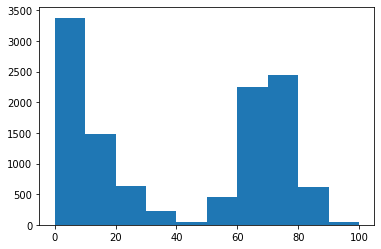

In [372]:
plt.hist(df['popularity'])

In [9]:
#Assign songs as popular or unpopular

#Compute the polarity into a sentiment positive / negative / neutral 

def getAnalysis(score):
    if score >= 50:
        return '1'
    else:
        return '0'
    
df['popularity1'] = df['popularity'].apply(getAnalysis)


df

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity1
0,J. Cole,Work Out,2wAJTrFhCnQyNSD3oUgTZO,81,0.831,0.427,2,-6.903,1,0.1060,0.053100,0.000000,0.3070,0.2160,93.004,235320,4,1
1,Otmar Eros,"Year 2016:, Pt. 4",1sUxW2zAmXA7lXHC8Dxu4s,24,0.241,0.064,5,-24.272,1,0.0602,0.994000,0.950000,0.0715,0.0372,141.739,69840,4,0
2,Rae Sremmurd,This Could Be Us,4jTiyLlOJVJj3mCr7yfPQD,79,0.732,0.690,0,-4.992,0,0.1340,0.291000,0.000000,0.1160,0.7580,143.072,206307,4,1
3,Midnight Oil,Forgotten Years - 2011 Remaster,6PrbbxJFuwDUUcgEjZW0jr,51,0.497,0.964,11,-2.653,0,0.0703,0.014900,0.000002,0.1190,0.5580,152.178,256573,4,1
4,JAY-Z,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,84,0.789,0.858,1,-5.542,1,0.3110,0.127000,0.000000,0.3490,0.7750,140.022,219333,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11575,Master,Hell Probably Win - Remaster 2022,7c0xeLh1Dun4gevWAQZKO7,5,0.379,0.987,0,-4.738,0,0.1880,0.000001,0.659000,0.5290,0.2480,160.097,157440,4,0
11576,Chris Jonex,Deja Que Tus Manos,1ONKgvfAhcbgHp4AKWAidI,80,0.538,0.785,2,-4.870,0,0.0296,0.142000,0.000000,0.3000,0.6310,146.066,160750,4,1
11577,Dan Barker,True Love - 2022 Remastered Version,3Oph7q1xVJPOesfVXQhSzW,0,0.757,0.671,9,-8.478,0,0.0799,0.130000,0.520000,0.7640,0.3080,99.991,196023,4,0
11578,Juice WRLD,Wandered To LA (with Justin Bieber),2DQayQSTaomynGyTLXzGs0,73,0.687,0.643,0,-4.763,1,0.0406,0.051800,0.000003,0.1100,0.4180,135.068,188833,4,1


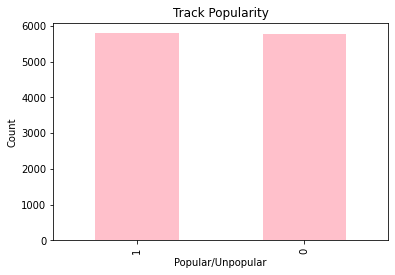

In [12]:
#Plot 

df['popularity1'].value_counts().plot(kind='bar', color='pink')
plt.title('Track Popularity')
plt.xlabel("Popular/Unpopular")
plt.ylabel("Count")
plt.show()

In [390]:
import numpy as np